<div style="text-align: right">
    <img src="img/BBWS2023_cropped.png" alt="" width="1200" id="hp"/>
</div>

# Tutorial 1: from BigBrains to BrainSpaces

🇮🇸 7th BigBrain Workshop, Reykjavík, Iceland, October 4 2023. By HBHL

**Content creators:** Jessica Royer, RaulR. Cruces, Boris Bernhardt. MICA lab

## 🐳 Tutorial Objectives

Estimated timing of tutorial: 40 minutes

### 🌋 Contextualization of BigBrain in a standarized MRI-compatible surface space
1. In this notebook we'll use the BigBrain intensities already mapped to an standarized brain surface (fsLR-32k **ref**). 
2. Build a microstructural profile covariance matrix derived from the BigBrain intensities
3. Use a dimentionality redution technique to highlight the major non-linear axis of variance from the MPC matrix.
4. Use a public MRI 3T database derivatives to assess the similarity between BigBrain histological stain intensities and a myelin-sensitive MRI acquisition.


### 🏔️ Overview:

1. Download the BigBrain intensity profiles using BrainSpace
2. Plot the mean intensities over the brain surface
3. Calculate the MPC matrix ROI-based 
4. Apply diffusion embeding mapping to get the main non-linear eigenvalues from the MPC-big.
5. Download qT1 MPC from the public repository MICs
6. Calculate the group-mean MPC
7. Apply diffusion embeding mapping to get the main non-linear eigenvalues from the MPC-mic.
8. Calculate the correlation of the gradients between MPC-big and MPC-mic
9. User a permutation test to validate the correlation 
10. Plot the correlation with ranked values.


### `Requirements`

<p></p>

<details><summary>▶️ click for details</summary>
<p>
   
```bash
git
bash -y conda -forge install
datalad
datalad-installer
datalad-installer git-annex -m datalad/git-annex:release
numpy
nilearn
wordcloud
matplotlib
pandas
scipy
h5py
pip "brainspace brainstat"
```

</p>
</details>

# BigBrain intensities on fsLR32k

<p></p>

<div style="text-align: right">
    <img src="img/bigbrain_mpc.png" alt="" width="800" id="hp"/>
</div>

> Paquola, Casey, et al. "The BigBrainWarp toolbox for integration of BigBrain 3D histology with multimodal neuroimaging." Elife 10 (2021): e70119. [10.7554/eLife.70119](https://doi.org/10.7554/eLife.70119) 


> Paquola, Casey, et al. "Microstructural and functional gradients are increasingly dissociated in transmodal cortices." PLoS biology 17.5 (2019): e3000284.  [0.1371/journal.pbio.3000284](https://doi.org/10.1371/journal.pbio.3000284)


# 1. Download the BigBrain intensity profiles using `BrainStats` 

In [1]:
import h5py
from brainstat.context.histology import download_histology_profiles

# Download the histology profile from BigBrain
# other template provided by BrainStat is: fsaverage
# For more templates check BigBrain Warp!
download_histology_profiles(data_dir='./', template='fslr32k', overwrite=True)
download_histology_profiles(data_dir='./', template='fsaverage5', overwrite=True)

# Read the file
h5 = h5py.File('./histology_fslr32k.h5','r')
histology_profiles=h5['fs_LR_64k']

# Read the file
h5 = h5py.File('./histology_fsaverage5.h5','r')
histology_profiles_fs5=h5['fsaverage5']

# Print file information
histology_profiles

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
2023-09-22 15:40:39,792 - numexpr.utils - INFO - Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-09-22 15:40:39,794 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2023-09-22 15:40:53,583 - brainstat - INFO - Downloading histology_fslr32k.h5 from https://box.bic.mni.mcgill.ca/s/6zKHcg9xXu5inPR/download.
2023-09-22 15:40:55,920 - brainstat - INFO - Downloading histology_fsaverage5.h5 from https://box.bic.mni.mcgill.ca/s/N8zstvuRb4sNcSe/download.


<HDF5 dataset "fs_LR_64k": shape (50, 64984), type "<f8">

In [2]:
from brainstat.datasets import fetch_template_surface

# Load surfaces
inf_left, inf_right = fetch_template_surface("fslr32k", join=False, layer='inflated')
fs5_left, fs5_right = fetch_template_surface("fsaverage5", join=False, layer='inflated')


<details><summary> ▶️ fetch_template_surface surfaces</summary>
<p>


> **template:** Cortical surface template to use. Valid values are ‘fsaverage5’, ‘fsaverage6’, ‘fsaverage’, ‘fslr32k’, ‘civet41k’, ‘civet164k’.
    
</p>
</details>

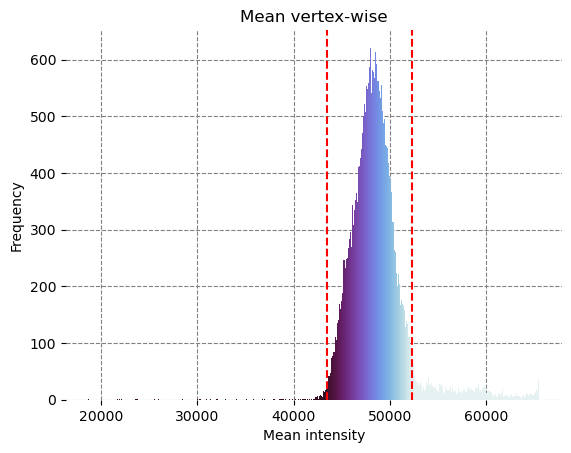

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean
import cmocean.cm as cmo

# Calculate vertex-wise mean intensity profile
histology_profiles_mean = np.mean(histology_profiles, axis=0)

# Calculate quantile range for plotting
Range=(np.quantile(histology_profiles_mean, 0.005), np.quantile(histology_profiles_mean, 0.925))

# Left subplot - Histogram for feature
n, bins, _ = plt.hist(histology_profiles_mean, bins=1000)
bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute the bin centers
colormap = cm.get_cmap('cmo.dense_r')
colored_bins = colormap(np.interp(bin_centers, [Range[0], Range[1]], [0, 1]))
plt.bar(bin_centers, n, width=np.diff(bins), color=colored_bins)
plt.xlabel('Mean intensity', fontsize=10)  # Increase font size for x-label
plt.ylabel('Frequency', fontsize=10)       # Increase font size for y-label
plt.title('Mean vertex-wise', fontsize=12)   # Increase font size for title

# Add vertical red lines at the values in Range
plt.axvline(Range[0], color='red', linestyle='--', label='Range Start')
plt.axvline(Range[1], color='red', linestyle='--', label='Range End')

# Remove the outer box line
for spine in plt.gca().spines.values():
    spine.set_visible(False)
# Set the grid on the back
plt.gca().set_axisbelow(True)
plt.grid(color='gray', linestyle='dashed')

# 2. Plot the mean intensities over the brain surface

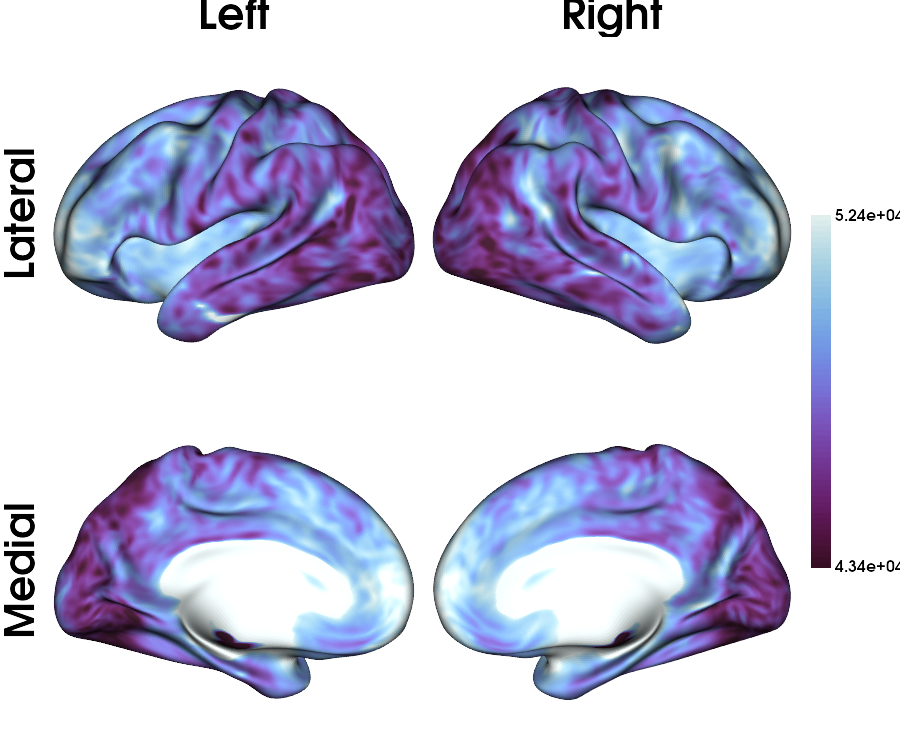

In [4]:
from brainspace.plotting import plot_hemispheres

# Plot the vertex-wise mean intensity profile
plot_hemispheres(inf_left, inf_right, 
                 array_name=histology_profiles_mean, 
                 nan_color=(0, 0, 0, 1),
                 zoom=1.3, 
                 size=(900, 750), 
                 embed_nb=True,
                 color_bar='right',
                 layout_style='grid',
                 color_range=Range,
                 cmap='cmo.dense_r',
                 label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}
                )

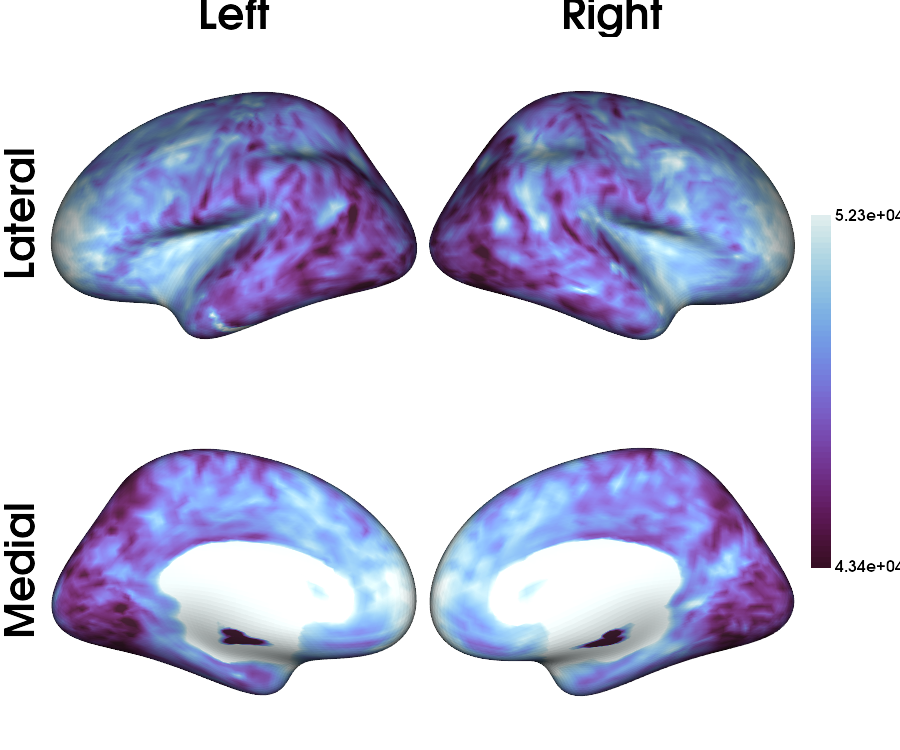

In [5]:
# Calculate vertex-wise mean intensity profile
histology_profiles_mean_fs5 = np.mean(histology_profiles_fs5, axis=0)

# Calculate quantile range for plotting
Range=(np.quantile(histology_profiles_mean_fs5, 0.005), np.quantile(histology_profiles_mean_fs5, 0.925))

# Plot the vertex-wise mean intensity profile
plot_hemispheres(fs5_left, fs5_right, 
                 array_name=histology_profiles_mean_fs5, 
                 nan_color=(0, 0, 0, 1),
                 zoom=1.3, 
                 size=(900, 750), 
                 embed_nb=True,
                 color_bar='right',
                 layout_style='grid',
                 color_range=Range,
                 cmap='cmo.dense_r',
                 label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}
                )

# 3. Calculate the BigBrain intensitites MPC matrix ROI-based

## What are the Microstructural profile covariance  🤔?
I dunno...

<div style="text-align: right">
<img src="https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/brain/146/9/10.1093_brain_awad125/1/awad125f1.jpeg?Expires=1697661260&Signature=iom0awZonSDzswt5gRNIdp5wK7KwVa-UGon3eJiJYD3iK9rGExDHDQ~AyhYiJCU-GLkPYePpcTLaEAhbmhPQD0Wqn-6pCUmT8g8xdJdWtaGZisfAq8L31jWndioJWp~R5IpRBMxMfbjSKDiK0JmmRj1HaBGSiSstFnAcdgHygsuI2d7NiEklw2jsE3SsClQWjWMd5jkmuJhT5t9N689INXt9kQeSmyEz9Yfi2WHcODKXUF0d13qO8uiBw9uC1KnvMRwzU3jSMOjw9GaSjhmrYwz9JwLVLpvGCwJ-9vqlvaYqoPgoxFNo~XqM5Xai8dhlK3oXnUpZT4lJCkh-CEan8A__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA" alt="" width="600" id="hp"/>
</div>

> Royer, Jessica, et al. "Cortical microstructural gradients capture memory network reorganization in temporal lobe epilepsy." Brain 146.9 (2023): 3923-3937. https://doi.org/10.1093/brain/awad125

## How they were calculated?
Vertex-wise intensity profiles were cross-correlated using partial correlations controlling for the average cortex-wide intensity profile, and log-transformed. This resulted in microstructural profile covariance (MPC) matrices representing participant-specific similarity in myelin proxies across the cortex

# 3. Calculate the BigBrain MPC matrix ROI-based 

In [6]:
from brainstat.datasets import fetch_parcellation

# Fetch an atlas parcellation
atlas = fetch_parcellation(template="fslr32k", atlas="schaefer", n_regions=800)

# Get the mask
mask = atlas != 0


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


2023-09-22 15:41:15,068 - nibabel.global - WARNING - pixdim[1,2,3] should be non-zero; setting 0 dims to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-09-22 15:41:15,071 - nibabel.global - INFO - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


<details><summary> ▶️ fetch_parcellation details</summary>
<p>
    
```python
def fetch_parcellation(
    template: str,
    atlas: str,
    n_regions: int,
    join: bool = True,
    seven_networks: bool = True,
    data_dir: Optional[Union[str, Path]] = None,
) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
    """Loads the surface parcellation of a given atlas.

    Parameters
    ----------
    template : str,
        The surface template. Valid values are "fsaverage", "fsaverage5",
        "fsaverage6", "fslr32k", "civet41k", "civet164k", by default "fsaverage5".
    atlas : str
        Name of the atlas. Valid names are "cammoun", "glasser", "schaefer", "yeo".
    n_regions : int
        Number of regions of the requested atlas. Valid values for the cammoun
        atlas are 33, 60, 125, 250, 500. Valid values for the glasser atlas are
        360. Valid values for the "schaefer" atlas are 100, 200, 300, 400, 500,
        600, 800, 1000. Valid values for "yeo" are 7 and 17.
    join : bool, optional
        If true, returns parcellation as a single array, if false, returns an
        array per hemisphere, by default True.
    seven_networks : bool, optional
        If true, uses the 7 networks parcellation. Only used for the Schaefer
        atlas, by default True.
    data_dir : str, pathlib.Path, optional
        Directory to save the data, defaults to $HOME_DIR/brainstat_data/parcellation_data.

    Returns
    -------
    np.ndarray or tuple of np.npdarray
        Surface parcellation. If a tuple, then the first element is the left hemisphere.
    """
```
    
</p>
</details>

Text(0.5, 23.52222222222222, 'ROI')

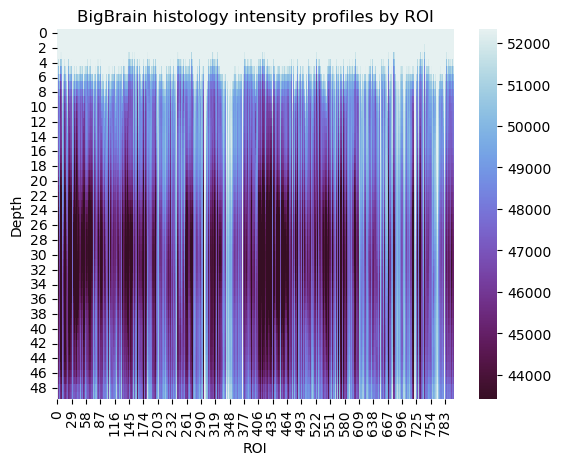

In [7]:
from brainspace.utils.parcellation import reduce_by_labels
import seaborn as sns

# Obtained the ROI based intensity profiles of Big Brain
histology_profiles_roi = reduce_by_labels(histology_profiles, atlas)

# PLot them 
ax = sns.heatmap(histology_profiles_roi, vmin=Range[0], vmax=Range[1], cmap='cmo.dense_r', square=False)
plt.title("BigBrain histology intensity profiles by ROI")
ax.set_ylabel("Depth")
ax.set_xlabel("ROI")


/host/yeatman/local_raid/rcruces/anaconda3/lib/python3.9/site-packages/brainstat/context/histology.py:105: RuntimeWarning: divide by zero encountered in true_divide
  mpc = 0.5 * np.log((1 + p_corr) / (1 - p_corr))
/host/yeatman/local_raid/rcruces/anaconda3/lib/python3.9/site-packages/brainstat/context/histology.py:105: RuntimeWarning: invalid value encountered in log
  mpc = 0.5 * np.log((1 + p_corr) / (1 - p_corr))


Text(0.5, 23.52222222222222, 'ROI')

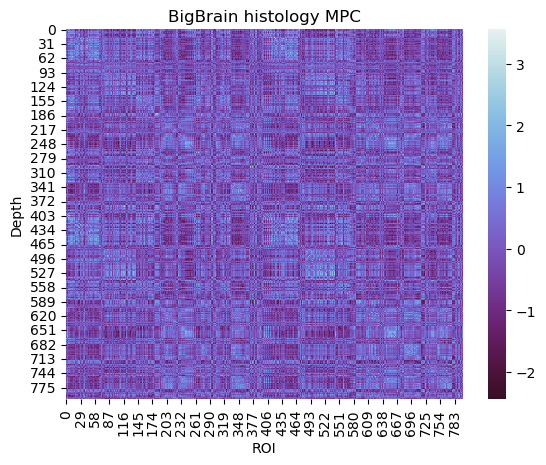

In [8]:
from brainstat.context.histology import compute_mpc

# Compute MPC
MPC_bb = compute_mpc(histology_profiles, labels=atlas)

# Plot the mean MPC matrix
ax = sns.heatmap(MPC_bb, cmap='cmo.dense_r', square=False)
plt.title("BigBrain histology MPC")
ax.set_ylabel("Depth")
ax.set_xlabel("ROI")

<details><summary> ▶️ compute_mpc details</summary>
<p>

```python
def compute_mpc(profile: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """Computes MPC for given labels on a surface template.

    Parameters
    ----------
    profile : numpy.ndarray
        Histological profiles of size surface-by-vertex.
    labels : numpy.ndarray
        Labels of regions of interest. Use 0 to denote regions that will not be included.

    Returns
    -------
    numpy.ndarray
        Microstructural profile covariance.
    """

    roi_profile = reduce_by_labels(profile, labels)
    if np.any(labels == 0):
        # Remove 0's in the labels.
        roi_profile = roi_profile[:, 1:]

    p_corr = partial_correlation(roi_profile, np.mean(profile, axis=1))

    mpc = 0.5 * np.log((1 + p_corr) / (1 - p_corr))
    mpc[p_corr > 0.99999] = 0  # Deals with floating point issues where p_corr==1
    mpc[mpc == np.inf] = 0
    mpc[mpc == np.nan] = 0

    return mpc
```

</p>
</details>

# 4. Apply diffusion embeding mapping to get the main non-linear eigenvalues from the MPC-bb

## What are the diffusion maps?

Is a non-linear algorithm useful in the context of data parametrization and dimensionality reduction. This method helps to simplify and understand complex data. t takes a set of data points and turns them into a map where distances between points represent how similar they are. This map is created by looking at how data spreads out over time, kind of like how heat spreads. 

It's different from other methods because it can handle noisy data and is not limited to straight lines. It helps reveal the underlying structure of the data. They can be applied to problem were linear methods like PCA fail (swiss roll and complex data). 

<div style="text-align: right">
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*bLs7TueTiMfznfCaIEvo8A.png" alt="" width="400" id="hp"/>
</div>


> Coifman RR, Lafon S. Diffusion maps. Applied and computational harmonic analysis. 2006 Jul 1;21(1):5-30. https://doi.org/10.1016/j.acha.2006.04.006

## How to apply the diffusion map method?

1. Starting from an input matrix (here, functional connectivity)
2. we use a kernel function to build the affinity matrix (here capturing the connectivity of each seed region).\
3. This matrix is decomposed, often via diffusion map embedding into a set of principal eigenvectors describing axes of largest variance. 
4. The scores of each seed onto the first two axes are shown in the scatter plot, with colors denoting position in this 2D space. 
5. These colors may be projected back to the cortical surface and the scores can be used to sort the input connectome.

<div style="text-align: right">
<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs42003-020-0794-7/MediaObjects/42003_2020_794_Fig1_HTML.png?as=webp" alt="" width="1000" id="hp"/>
</div>

## `BrainSpace`


> Vos de Wael, R., Benkarim, O., Paquola, C. et al. BrainSpace: a toolbox for the analysis of macroscale gradients in neuroimaging and connectomics datasets. Commun Biol 3, 103 (2020). https://doi.org/10.1038/s42003-020-0794-7 

## What does the diffusion maps tell us about the brain organization?



<div style="text-align: right">
<img src="https://ars.els-cdn.com/content/image/1-s2.0-S1053811922001161-gr1_lrg.jpg" alt="" width="500" id="hp"/>
</div>

> Bernhardt BC, Smallwood J, Keilholz S, Margulies DS. Gradients in brain organization. NeuroImage. 2022 May 1;251:118987. https://doi.org/10.1016/j.neuroimage.2022.118987

In [9]:
from brainspace.gradient import GradientMaps

# Define the number of gradiants to calculate
Ngrad=10

# kernel = None, 'pearson', 'spearman', 'normalized_angle'
gradient_bb = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
gradient_bb.fit(MPC_bb, sparsity=0.9)

GradientMaps(kernel='normalized_angle')

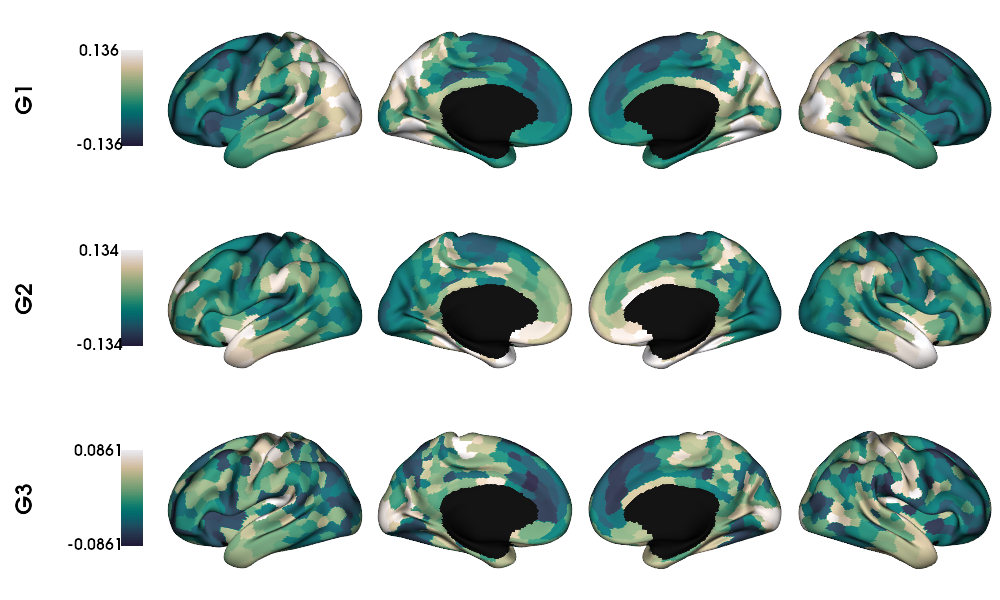

In [10]:
from brainspace.utils.parcellation import map_to_labels

# Map gradients to original parcels
Nplot=3
vertexwise_gradient = [None] * Nplot
for i, g in enumerate(gradient_bb.gradients_.T[0:Nplot,:]):
    vertexwise_gradient[i] = map_to_labels(g, atlas, fill=np.nan, mask=mask != 0)

ylab=['G'+str(x) for x in list(range(1,Nplot+1))]
plot_hemispheres(inf_left, inf_right, 
                 array_name=vertexwise_gradient, 
                 size=(1000, 600), 
                 cmap='cmo.rain_r',
                  embed_nb=True,  
                 label_text={'left':ylab}, 
                 color_bar='left',
                 zoom=1.25, 
                 nan_color=(0, 0, 0, 1), 
                 color_range='sym' )

# 5. Download qT1 MPC from the public repository MICs
This data is part of the derivatives that were generated using micapipe from the Microstructure-Informed Connectomics (MICs) open dataset avaliable at the CONP portal (https://n2t.net/ark:/70798/d72xnk2wd397j190qv ).


## Why quantitative T1 mapping (qT1)?
Thats what we have, deal with it
also thought to be myelin-sensitive. We have here a putative myelin-sensitive MRI marker, T1 relaxometry.

measurement of longitudinal relaxation time (T1) on MRI, referred to as quantitative T1 mapping (qT1), may be sensitive to grey matter myelin conten.
<div style="text-align: right">
<img src="https://ars.els-cdn.com/content/image/1-s2.0-S1053811914001359-gr1_lrg.jpg" alt="" width="800" id="hp"/>
</div>

> Stüber, Carsten, et al. "Myelin and iron concentration in the human brain: a quantitative study of MRI contrast." Neuroimage 93 (2014): 95-106. https://doi.org/10.1016/j.neuroimage.2014.02.026


## How to get MRI based MPC matrices?

1. Calculate your own MPC matrices processing your quantitative MRI with `micapipe` MPC processing ([click here for mode details](https://micapipe.readthedocs.io/en/latest/pages/02.microstructproc/index.html)). 

<div style="text-align: right">
<a href="https://micapipe.readthedocs.io/en/latest/index.html"><img src="https://raw.githubusercontent.com/MICA-MNI/micapipe/master/docs/figures/micapipe.png" alt="" width="200" id="hp"/>
</div>


2. Use an online already processed datase like **MICA-MICs**: a dataset for Microstructure-Informed Connectomics. MICs is hosted on The Canadian Open Neuroscience Platform:  https://portal.conp.ca/dataset?id=projects/mica-mics

<div style="text-align: right">
<a href="https://portal.conp.ca/dataset?id=projects/mica-mics"><img src="https://portal.conp.ca/dataset_logo?id=projects/mica-mics" alt="" width="200" id="hp"/>
</div>
    
> Royer, Jessica, et al. "An open MRI dataset for multiscale neuroscience." Scientific Data 9.1 (2022): 569. https://doi.org/10.1093/brain/awad125

## Download the data using `datalad`
> Requires `git` and `git-annex`. For more information installing datalad [click here](https://handbook.datalad.org/en/latest/intro/installation.html#install).

In [11]:
%%bash

# Initialite the CONP dataset
datalad install https://github.com/CONP-PCNO/conp-dataset.git

# Install the mica-mics dataset
cd conp-dataset
datalad install projects/mica-mics

tree -d projects/mica-mics/MICs_release/derivatives/micapipe/sub-HC001/*

install(notneeded): /host/yeatman/local_raid/rcruces/git_here/2023_BigBrain_workshop_BigBrains-BrainSpaces/code/conp-dataset (dataset) [dataset <Dataset path=/host/yeatman/local_raid/rcruces/git_here/2023_BigBrain_workshop_BigBrains-BrainSpaces/code/conp-dataset> was already cloned from 'https://github.com/CONP-PCNO/conp-dataset.git']
get(notneeded): /host/yeatman/local_raid/rcruces/git_here/2023_BigBrain_workshop_BigBrains-BrainSpaces/code/conp-dataset/projects/mica-mics (dataset) [already installed]
projects/mica-mics/MICs_release/derivatives/micapipe/sub-HC001/ses-01
├── anat
│   ├── geo_dist
│   └── micro_profiles
├── dwi
│   └── eddy
└── func

6 directories


In [12]:
%%bash 

# Get only the MPC matrices of schaeffer-1000
cd conp-dataset
atlas=schaefer800

datalad get projects/mica-mics/MICs_release/derivatives/micapipe/sub-*/ses-*/anat/micro_profiles/*_space-fsnative_atlas-${atlas}_desc-mpc.txt

# Get the participants demografics
datalad get projects/mica-mics/MICs_release/rawdata/participants.tsv


get(notneeded): /host/yeatman/local_raid/rcruces/git_here/2023_BigBrain_workshop_BigBrains-BrainSpaces/code/conp-dataset/projects/mica-mics/MICs_release/derivatives/micapipe/sub-HC001/ses-01/anat/micro_profiles/sub-HC001_ses-01_space-fsnative_atlas-schaefer800_desc-mpc.txt (file) [already present]
get(notneeded): /host/yeatman/local_raid/rcruces/git_here/2023_BigBrain_workshop_BigBrains-BrainSpaces/code/conp-dataset/projects/mica-mics/MICs_release/derivatives/micapipe/sub-HC002/ses-01/anat/micro_profiles/sub-HC002_ses-01_space-fsnative_atlas-schaefer800_desc-mpc.txt (file) [already present]
get(notneeded): /host/yeatman/local_raid/rcruces/git_here/2023_BigBrain_workshop_BigBrains-BrainSpaces/code/conp-dataset/projects/mica-mics/MICs_release/derivatives/micapipe/sub-HC003/ses-01/anat/micro_profiles/sub-HC003_ses-01_space-fsnative_atlas-schaefer800_desc-mpc.txt (file) [already present]
get(notneeded): /host/yeatman/local_raid/rcruces/git_here/2023_BigBrain_workshop_BigBrains-BrainSpaces/

# 6. Load all the MICs MPC matrices 

In [12]:
import glob

# Cuntion to load and prepare the MPC matrices
def load_mpc(path):
    # Load the cortical connectome
    mtx_mpc = np.loadtxt(path, dtype=np.float, delimiter=' ')

    # Fill the lower triangle of the matrix
    MPC = np.triu(mtx_mpc,1)+mtx_mpc.T

    # Renove the medial wall
    MPC = np.delete(np.delete(MPC, 0, axis=0), 0, axis=1)
    MPC = np.delete(np.delete(MPC, 400, axis=0), 400, axis=1)
    
    # replace values close to 0
    MPC[MPC==0] = np.finfo(float).eps
    return(MPC)

# Load all the files
parc = "schaefer800"
MPC_files=sorted(glob.glob(f"conp-dataset/projects/mica-mics/MICs_release/derivatives/micapipe/sub-*/ses-*/anat/micro_profiles/*_space-fsnative_atlas-{parc}_desc-mpc.txt"))

# Get the dimensions of the MPC matrix
Ndim=load_mpc(MPC_files[0]).shape[0]

# Load all the  MPC matrices as array
MPC_mics=np.empty([Ndim, Ndim, len(MPC_files)], dtype=float)
for i, f in enumerate(MPC_files):
    #print(f)
    MPC_mics[:,:,i] = load_mpc(f)

# Print the shape of all the loaded MPCs
print(MPC_mics.shape)

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_13607/1699934321.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mtx_mpc = np.loadtxt(path, dtype=np.float, delimiter=' ')


(800, 800, 50)


# 7. Calculate the group-mean MPC and visualize it

(800, 800)

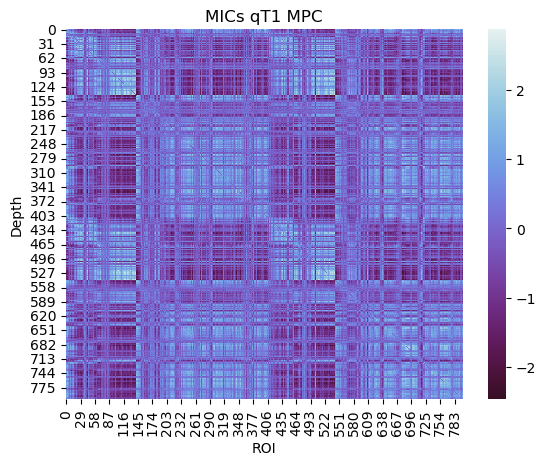

In [13]:
# Caculate the group mean MPC
MPC_mics_mean = np.mean(MPC_mics, axis=2)

# Plot the mean MPC matrix
ax = sns.heatmap(MPC_mics_mean, cmap='cmo.dense_r', square=False)
plt.title("MICs qT1 MPC")
ax.set_ylabel("Depth")
ax.set_xlabel("ROI")
MPC_mics_mean.shape

# 8. Apply diffusion embeding mapping to get the main non-linear eigenvalues from the MPC-mic.

In [14]:
# Define the number of gradiants to calculate
Ngrad=10

# Calculate the gradients
gradient_mics = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
gradient_mics.fit(MPC_mics_mean, sparsity=0.8)


GradientMaps(kernel='normalized_angle')

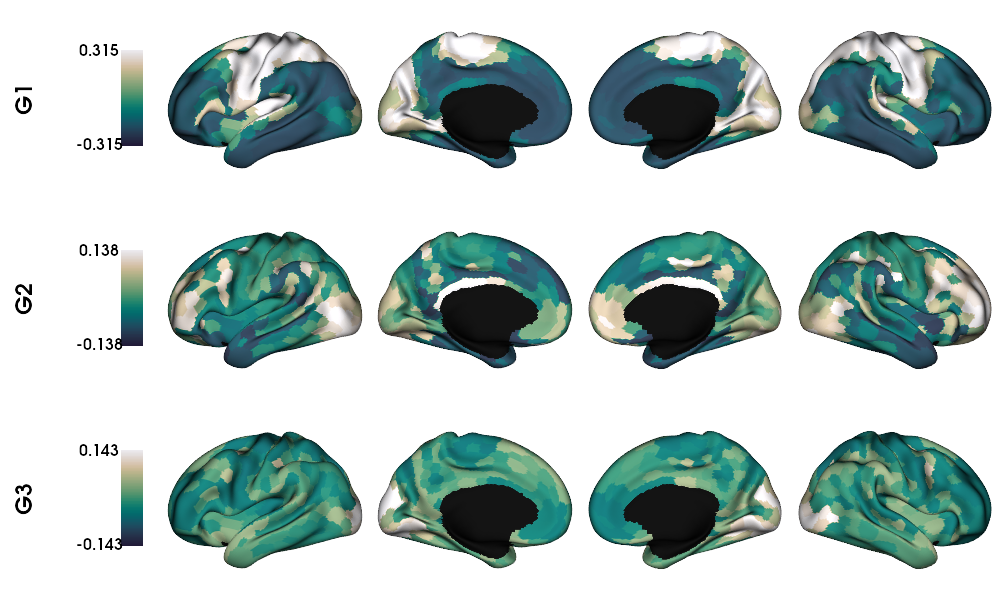

In [15]:
# Map gradients to original parcels
Nplot=3
vertexwise_gradient = [None] * Nplot
for i, g in enumerate(gradient_mics.gradients_.T[0:Nplot,:]):
    vertexwise_gradient[i] = map_to_labels(g, atlas, fill=np.nan, mask=mask != 0)

ylab=['G'+str(x) for x in list(range(1,Nplot+1))]
plot_hemispheres(inf_left, inf_right, 
                 array_name=vertexwise_gradient, 
                 size=(1000, 600), 
                 cmap='cmo.rain_r',
                  embed_nb=True,  
                 label_text={'left':ylab}, 
                 color_bar='left',
                 zoom=1.25, 
                 nan_color=(0, 0, 0, 1), 
                 color_range='sym' )

# 9. Is there a correlation between the MPC-bigbrain and MPC-mics?

In [16]:
corr_bb_mics = np.corrcoef(gradient_mics.gradients_, gradient_bb.gradients_, rowvar=False)
corr_bb_mics.shape

(20, 20)

Text(0.5, 23.52222222222222, 'Gradients MPC-MICs')

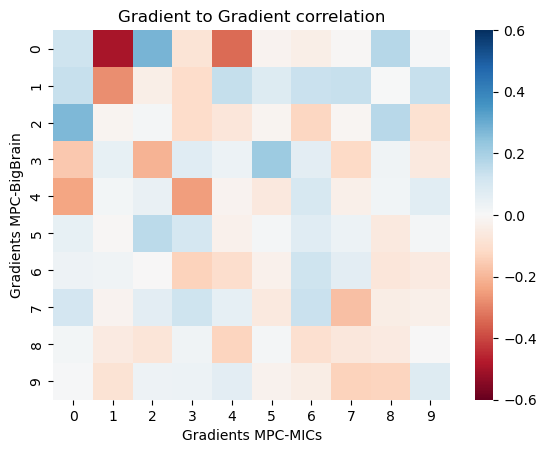

In [17]:
# Plot the mean MPC matrix
ax = sns.heatmap(corr_bb_mics[:10,10:], cmap='RdBu', square=False, vmin=-0.6, vmax=0.6)
plt.title("Gradient to Gradient correlation")
ax.set_ylabel("Gradients MPC-BigBrain")
ax.set_xlabel("Gradients MPC-MICs")

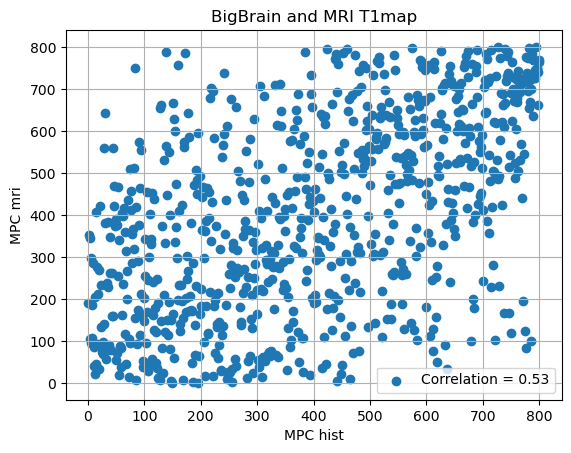

In [21]:
from scipy.stats import spearmanr
from scipy.stats import rankdata

# Calculate the correlation coefficient
g2_his = gradient_bb.gradients_[:,1]*-1
g1_mri = gradient_mics.gradients_[:,0]

# Remove NaN values
valid_indices = ~np.isnan(g2_his) & ~np.isnan(g1_mri)
g2_his = rankdata(g2_his[valid_indices])
g1_mri = rankdata(g1_mri[valid_indices])
#g1_his = g1_his[valid_indices]
#g1_mri = g1_mri[valid_indices]

# Calculate the Spearman rank correlation coefficient
correlation_coefficient, _ = spearmanr(g2_his, g1_mri)

# Create a scatter plot
plt.scatter(g2_his, g1_mri, label=f'Correlation = {correlation_coefficient:.2f}')
plt.xlabel('MPC hist')
plt.ylabel('MPC mri')
plt.title('BigBrain and MRI T1map')
plt.legend()
plt.grid(True)

## Ranked G2 from BigBrain on the surface

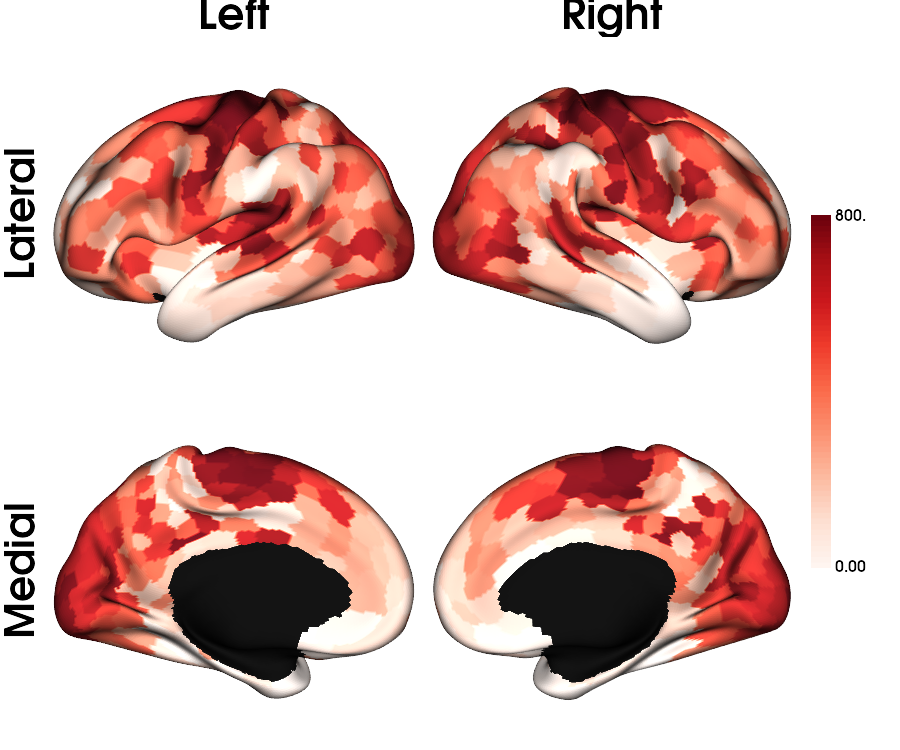

In [22]:
# Map the ROI to the surface vertices for plotting
g2_his_vertex = map_to_labels(g2_his, atlas, fill=np.nan, mask=mask != 0)

# Plot the vertex-wise mean intensity profile
plot_hemispheres(inf_left, inf_right, 
                 array_name=g2_his_vertex, 
                 nan_color=(0, 0, 0, 1),
                 zoom=1.3, 
                 size=(900, 750), 
                 embed_nb=True,
                 color_bar='right',
                 layout_style='grid',
                 color_range=(0, Ndim),
                 cmap='Reds',
                 label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}
                )

## Context decoding of MPC BigBrain G2 - sensory fugal

In [49]:
from brainstat.context.meta_analysis import meta_analytic_decoder
from wordcloud import WordCloud

meta_analysis = meta_analytic_decoder("fslr32k", g2_his_vertex, data_dir='./Neurosynth')
print(meta_analysis)

2023-09-22 16:46:02,477 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2023-09-22 16:46:03,007 - brainstat - INFO - Running correlations with all Neurosynth features.
                      Pearson's r
executed                 0.529401
movement                 0.528379
movements                0.523245
sensorimotor cortex      0.520337
sensorimotor             0.515589
...                           ...
medial orbitofrontal    -0.231197
amygdala hippocampus    -0.256007
temporal pole           -0.265980
anterior temporal       -0.270499
dementia                -0.346931

[3228 rows x 1 columns]


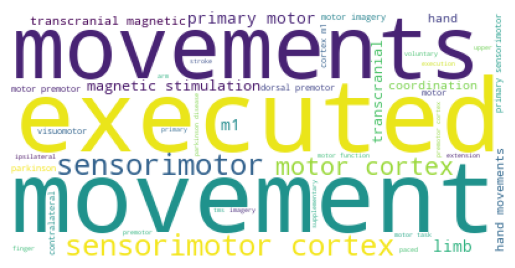

In [50]:
wc = WordCloud(background_color="white", random_state=0)
wc.generate_from_frequencies(frequencies=meta_analysis.to_dict()["Pearson's r"])
plt.imshow(wc)
plt.axis("off")
plt.show()

## Ranked G1 from MICs-MRI on the surface

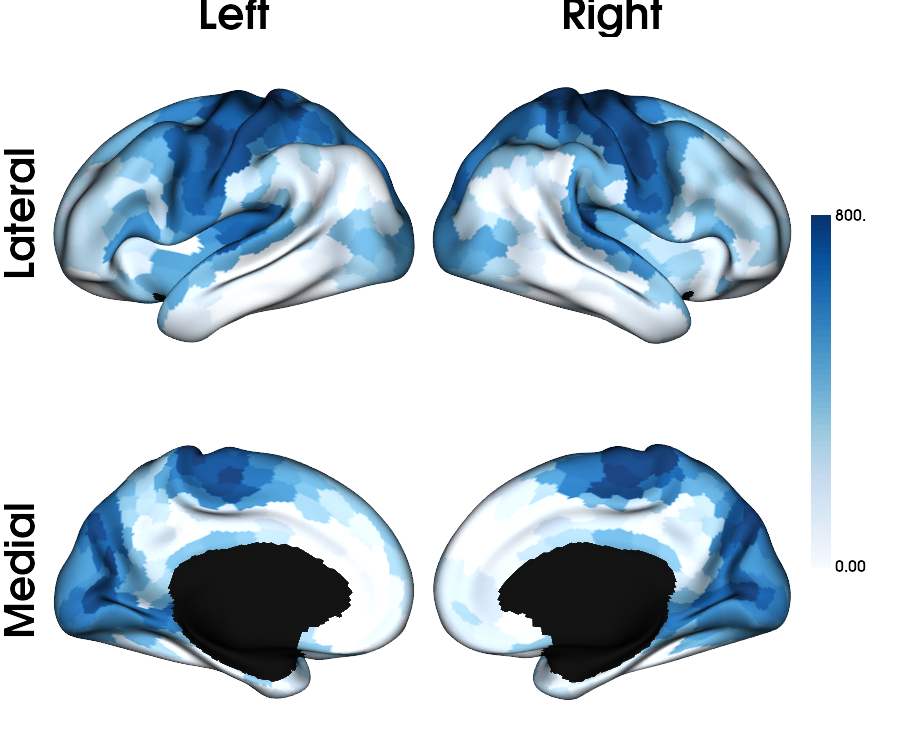

In [51]:
# Map the ROI to the surface vertices for plotting
g1_mri_vertex = map_to_labels(g1_mri, atlas, fill=np.nan, mask=mask != 0)

# Plot the vertex-wise mean intensity profile
plot_hemispheres(inf_left, inf_right, 
                 array_name=g1_mri_vertex, 
                 nan_color=(0, 0, 0, 1),
                 zoom=1.3, 
                 size=(900, 750), 
                 embed_nb=True,
                 color_bar='right',
                 layout_style='grid',
                 color_range=(0, Ndim),
                 cmap='Blues',
                 label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}
                )

## Context decoding of MPC BigBrain G2 - sensory fugal

2023-09-22 16:49:18,937 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2023-09-22 16:49:19,029 - brainstat - INFO - Running correlations with all Neurosynth features.
                      Pearson's r
executed                 0.529401
movement                 0.528379
movements                0.523245
sensorimotor cortex      0.520337
sensorimotor             0.515589
...                           ...
medial orbitofrontal    -0.231197
amygdala hippocampus    -0.256007
temporal pole           -0.265980
anterior temporal       -0.270499
dementia                -0.346931

[3228 rows x 1 columns]


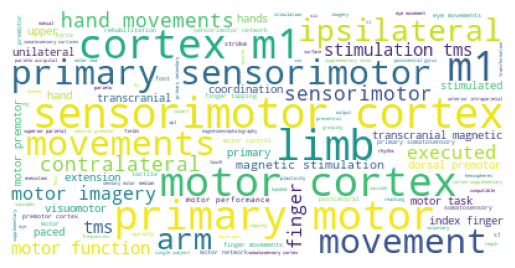

In [52]:
meta_analysis_G1 = meta_analytic_decoder("fslr32k", g1_mri_vertex, data_dir='./Neurosynth')
print(meta_analysis)

wc = WordCloud(background_color="white", random_state=0)
wc.generate_from_frequencies(frequencies=meta_analysis_G1.to_dict()["Pearson's r"])
plt.imshow(wc)
plt.axis("off")
plt.show()

# Maximun similarity between the ranked ROIs

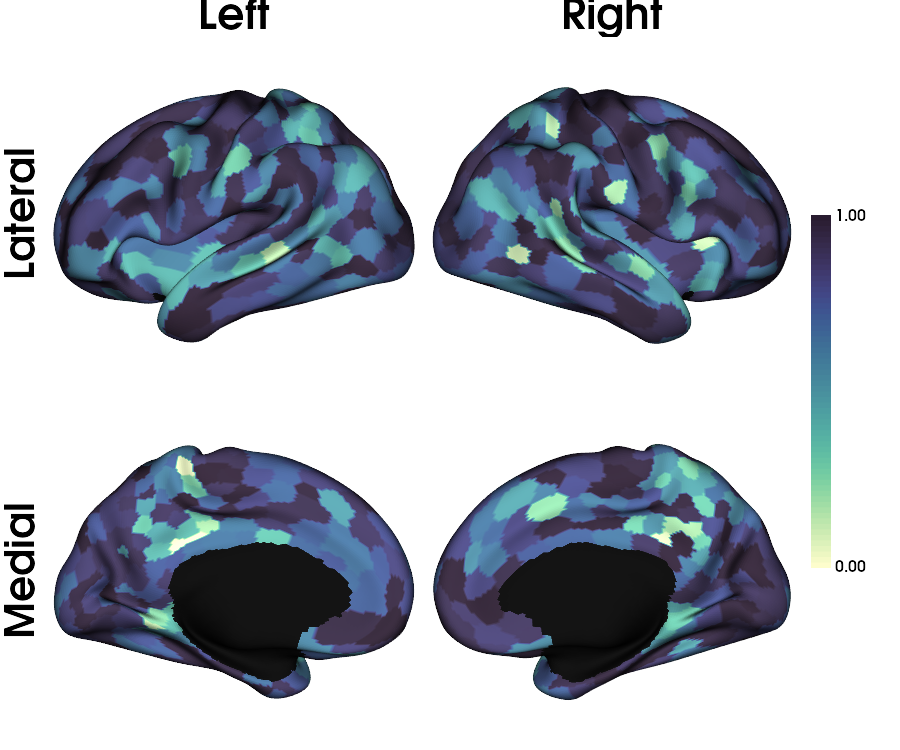

In [54]:
# Calculate the ROI with highest similituded between G2-BigBrain and G1-MRI
g1g2 = (np.abs(g1_mri-g2_his) - np.max(np.abs(g1_mri-g2_his)) )*-1

# Normalize the values between 0 and 1
g1g2_norm = (g1g2-np.min(g1g2))/(np.max(g1g2)-np.min(g1g2))

g1g2_vertex = map_to_labels(g1g2_norm, atlas, fill=np.nan, mask=mask != 0)

# Plot the vertex-wise mean intensity profile
plot_hemispheres(inf_left, inf_right, 
                 array_name=g1g2_vertex, 
                 nan_color=(0, 0, 0, 1),
                 zoom=1.3, 
                 size=(900, 750), 
                 embed_nb=True,
                 color_bar='right',
                 layout_style='grid',
                 cmap='cmo.deep',
                 label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}
                )

# 10. Use a permutation test to validate the correlation

## Why do we use a permutation test?

 Given the spatial autocorrelation present in many modalities, applying linear regression or similar methods may provide biased test statistics. To circumvent this issue, we recommend comparing the observed test statistic to those of a set of distributions with similar spatial autocorrelation. To this end, we provide two methods: spin permutations46 and Moran spectral randomization (MSR)56,57. In cases where the input data lies on a surface and most of the sphere is used or if data can be mapped to a sphere, we recommend spin permutation. Otherwise, we recommend MSR. When performing a statistical test with multiple gradients as either predictor or response variable, we recommend randomizing the non-gradient variable as these randomizations need not maintain statistical independence across different eigenvectors.

https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs42003-020-0794-7/MediaObjects/42003_2020_794_Fig10_HTML.png?as=webp

In [35]:
from brainspace.null_models import SpinPermutations
from brainspace.datasets import load_conte69

sphere_lh, sphere_rh = load_conte69(as_sphere=True)

# Let's create some rotations
n_rand = 1000

sp = SpinPermutations(n_rep=n_rand, random_state=0)
sp.fit(sphere_lh, points_rh=sphere_rh)


SpinPermutations(n_rep=1000, random_state=0)

In [ ]:
t1wt2w_rotated = np.hstack(sp.randomize(t1wt2w_lh, t1wt2w_rh))
thickness_rotated = np.hstack(sp.randomize(thickness_lh, thickness_rh))

# Open  tools

## BigBrainWarp
<div style="text-align: right">
<a href="https://bigbrainwarp.readthedocs.io/en/latest/"><img src="https://bigbrainwarp.readthedocs.io/en/latest/_static/warp2.png" alt="" width="200" id="hp"/>
</div>   

## Brainspace

<div style="text-align: right">
<a href="https://brainspace.readthedocs.io/en/latest/"><img src="https://mica-mni.github.io/assets/BRAINSPACE_LOGO.png" alt="" width="400" id="hp"/>
</div>

## BrainStats
<div style="text-align: right">
<a href="https://brainstat.readthedocs.io/en/master/"><img src="https://raw.githubusercontent.com/MICA-MNI/BrainStat/master/docs/figures/brainstat_logo_bw.png" alt="" width="400" id="hp"/>
</div>    

## MICs
<div style="text-align: right">
<a href="https://portal.conp.ca/dataset?id=projects/mica-mics"><img src="https://micapipe.readthedocs.io/en/latest/_images/mics_logo.png" alt="" width="200" id="hp"/>
</div>    
    
    
## micapipe
<div style="text-align: right">
<a href="https://micapipe.readthedocs.io/en/latest/"><img src="https://raw.githubusercontent.com/MICA-MNI/micapipe/master/docs/figures/micapipe.png" alt="" width="200" id="hp"/>
</div>    
    
